In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

In [2]:
num_stops = 30
num_params = 10
num_markov = 30

In [3]:
markov_probs1 = jnp.full(num_params, 0.95)
x_range = jnp.linspace(0, num_markov-1, num_params)

In [4]:
x = jnp.arange(30)
passengers_real = 2*x - 1/30*x**2

passengers_arrive = jnp.full(num_stops,2)

In [5]:
cum_probs = jnp.cumprod(markov_probs1)
    
jax.numpy.interp(jnp.arange(num_markov), x_range, cum_probs)

Array([0.95      , 0.9352586 , 0.9205172 , 0.90577585, 0.89160776,
       0.8776034 , 0.8635991 , 0.8499838 , 0.8366797 , 0.8233756 ,
       0.8102932 , 0.79765433, 0.78501546, 0.77244675, 0.7604398 ,
       0.7484329 , 0.7364259 , 0.7249526 , 0.713546  , 0.7021394 ,
       0.691113  , 0.68027675, 0.6694405 , 0.658845  , 0.64855057,
       0.63825613, 0.6280761 , 0.6182963 , 0.6085166 , 0.5987368 ],      dtype=float32)

In [33]:
@jax.jit
def simulate_crv(passengers_arrive, probs):
    passengers = jnp.zeros(num_stops)
    for i in range(num_stops):
        end = min(num_stops-i,num_markov)
        passengers = passengers + jax.lax.dynamic_update_slice(jnp.zeros(num_stops), passengers_arrive[i]*probs[:end], (i,))
    return passengers

@jax.jit
def simulate_markov(passengers_arrive, markov_probs):
    cum_probs = jnp.cumprod(markov_probs)
    
    cum_probs_interp = jax.numpy.interp(jnp.arange(num_markov), x_range, cum_probs)

    passengers = jnp.zeros(num_stops)
    for i in range(num_stops):
        end = min(num_stops-i,num_markov)
        passengers = passengers + jax.lax.dynamic_update_slice(jnp.zeros(num_stops), passengers_arrive[i]*cum_probs_interp[:end], (i,))
    return passengers


@jax.jit
def loss_crv(params, y): 
    cdf = lambda x: jax.scipy.stats.gamma.cdf(x, *params)
    probs = 1 - cdf(jnp.arange(num_markov))
    passengers = simulate_crv(passengers_arrive, probs)
    return jnp.sum((passengers - y)**2)

@jax.jit
def loss_markov(markov_probs, y): 
    passengers = simulate_markov(passengers_arrive, markov_probs)
    return jnp.sum((passengers - y)**2)

In [34]:
grad_loss1 = jax.value_and_grad(loss_markov)
grad_loss2 = jax.value_and_grad(loss_crv)

In [35]:
theta1 = jnp.copy(markov_probs1)
theta2 = jnp.array([1.,1.])

In [36]:
lr = 0.00001

for i in range(100):
    value, grad = grad_loss1(theta1, passengers_real)
    theta1 = theta1 - lr*grad

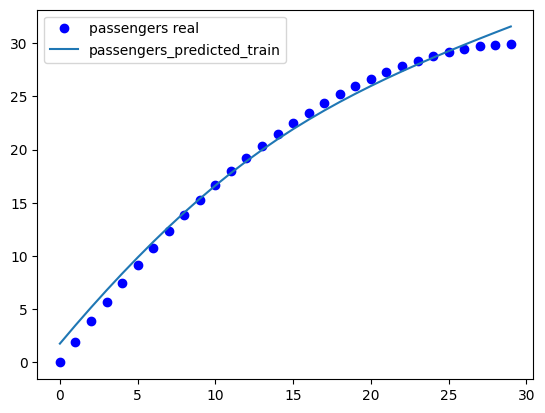

In [37]:
plt.plot(passengers_real, 'bo', label='passengers real', )
plt.plot(simulate_markov(passengers_arrive, theta1), label='passengers_predicted_train')
#plt.plot(passengers_predicted, label='passengers_predicted')
plt.legend()

In [50]:
lr = 0.001

theta2 = jnp.array([5., 5.])
for i in range(500):
    value, grad = grad_loss2(theta2, passengers_real)
    theta2 = theta2 - lr*grad
    if i%10==0:
        print(value)

766.52136
300.69818
297.8053
297.4193
297.0547
296.6914
296.3296
295.9688
295.60925
295.25092
294.8938
294.5381
294.18335
293.82993
293.47736
293.12628
292.77625
292.4273
292.0795
291.7329
291.3873
291.04285
290.69968
290.35745
290.0164
289.67642
289.33746
288.99954
288.6628
288.3271
287.9925
287.65878
287.32614
286.9946
286.66412
286.33466
286.0063
285.67874
285.3523
285.0267
284.70218
284.37875
284.0563
283.7347
283.41403
283.09436
282.77576
282.45807
282.14108
281.82526


[8.480276 4.374593]


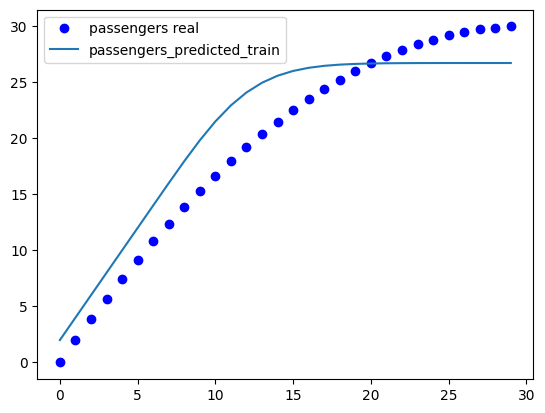

In [52]:
print(theta2)
cdf = lambda x: jax.scipy.stats.gamma.cdf(x, *theta2)
probs = 1 - cdf(jnp.arange(num_markov))
plt.plot(passengers_real, 'bo', label='passengers real', )
plt.plot(simulate_crv(passengers_arrive, probs), label='passengers_predicted_train')
#plt.plot(passengers_predicted, label='passengers_predicted')
plt.legend()

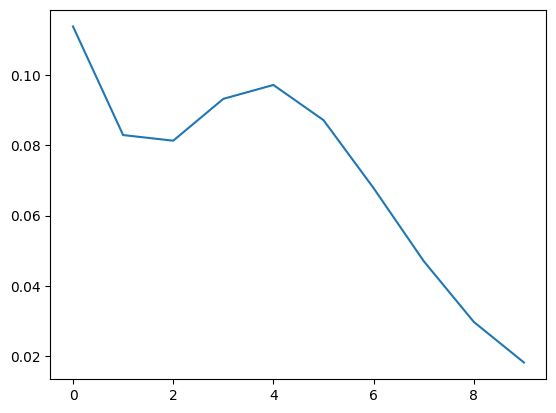

In [55]:
pdf = []
cumulate=1
for i in theta1:
    pdf += [cumulate*(1-i)]
    cumulate*=i

plt.plot(pdf)

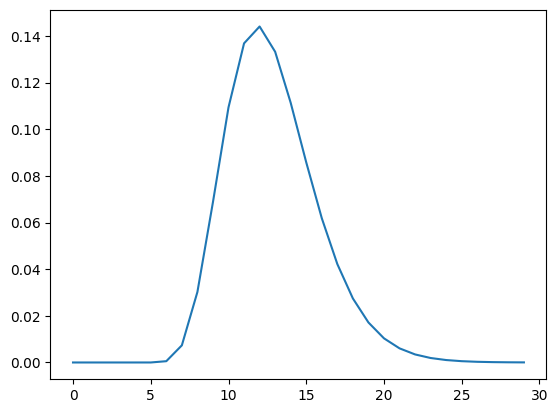

In [57]:
plt.plot(jax.scipy.stats.gamma.pdf(jnp.arange(num_stops), *theta2))